### Урок 9. Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Датасет

In [5]:
df = pd.read_csv("результаты А_B - cookie_cats 2.csv")

df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


### Описательная статистика

In [8]:
df["userid"].count() == df["userid"].nunique()


True

нет повторяющихся пользователей

In [6]:
df["userid"].nunique()


90189

In [7]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


выборки допустимо одинаковы

In [11]:
# Подсчет количества игроков для каждого количества игровых раундов
plot_df = df.groupby("sum_gamerounds")["userid"].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Построение графика распределения игроков, сыгравших от 0 до 100 игровых раундов

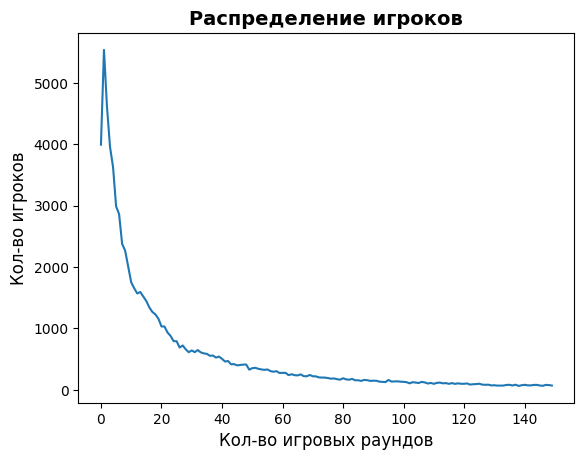

In [40]:
ax = plot_df.head(150).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("Кол-во игровых раундов", size=12)
plt.ylabel("Кол-во игроков", size=12)
plt.show()

In [41]:
df.query("sum_gamerounds == 0").userid.count()

3994

In [42]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"коэффициент удержания на 1 день: {round(df_retention[0],2)}% \
      \nкоэффициент удержания за 7 день {round(df_retention[1],2)}%")

коэффициент удержания на 1 день: 44.52%       
коэффициент удержания за 7 день 18.61%


Это кол-во игроков которые установили но не запустили игру, что видно по графику выше.<br>
чуть меньше половины игроков возвращаются через день после установки игры. 18.61% игроков возвращаются через 7 дней после установки игры.

###  Bootstrapping


In [43]:
boot_1d = pd.DataFrame([df.sample(frac=1, replace=True).groupby(
    'version')['retention_1'].mean() for _ in range(3000)])
boot_7d = pd.DataFrame([df.sample(frac=1, replace=True).groupby(
    'version')['retention_7'].mean() for _ in range(3000)])

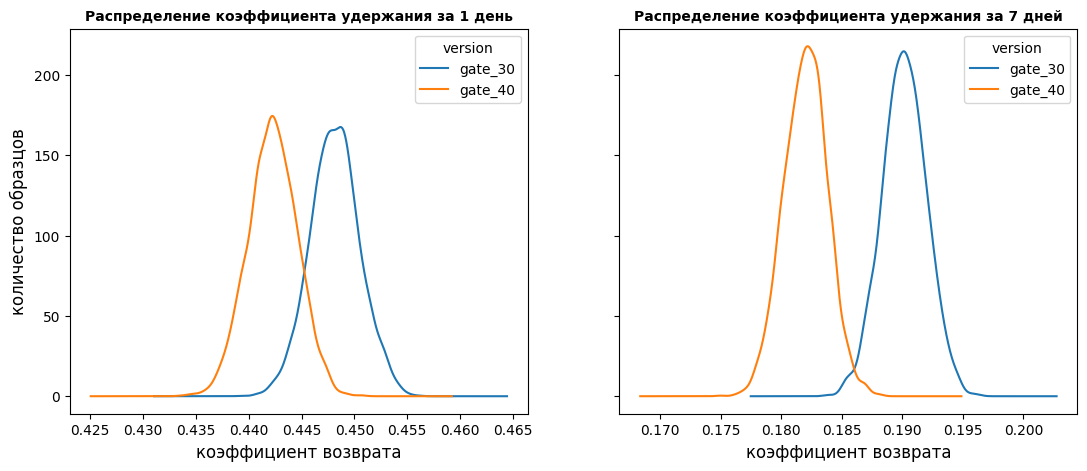

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))
boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент возврата",size=12)
ax1.set_ylabel("количество образцов",size=12)
ax1.set_title("Распределение коэффициента удержания за 1 день", fontweight="bold",size=10)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент возврата",size=12)
ax2.set_title("Распределение коэффициента удержания за 7 дней", fontweight="bold",size=10)
plt.show()

Эти распределения представляют собой неопределенность Bootstrapping относительно того, каким может быть удержание  за 1 и 7 дней<br> по графикам видно что есть некоторая разница, но не достаточно.
- Увеличим различия  

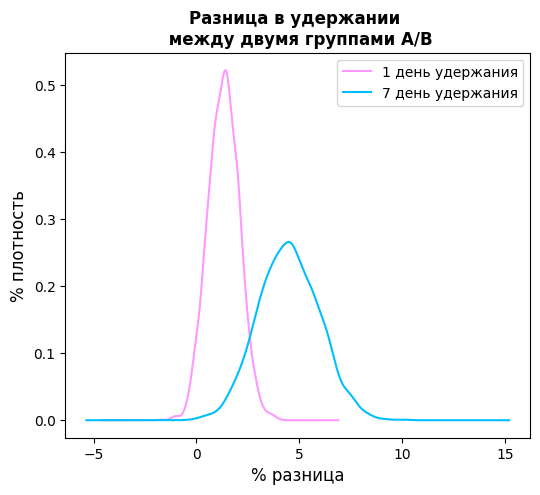

In [44]:
# Добавление столбца с разницей в % между двумя группами A/B
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)
# Построение графика разницы в % начальной загрузки
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 день удержания")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 день удержания")
ax1.set_xlabel("% разница",size=12)
ax1.set_ylabel("% плотность",size=12)
ax1.set_title("Разница в удержании \n между двумя группами A/B", fontweight="bold", size=12)
plt.legend()
plt.show()

Из этой диаграммы мы можем видеть, что наиболее вероятная разница в процентах составляет около 1-2% при удержании в течение 1 дня. При 7-дневном хранении наиболее вероятная разница в процентах составляет около 2-5%. Более того, большая часть распределения выше 0% в пользу ворот на 30 уровне. Но какова вероятность того, что разница превысит 0%? Давайте подсчитаем и это тоже.

In [34]:
# Вычисление вероятности того, что удержание в течение 1 дня будет больше, когда врата находятся на уровне 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
# Вычисление вероятности того, что 7-дневное удержание будет больше, когда врата находятся на уровне 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f"Вероятность того, что 1-дневное удержание больше, когда врата находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность 7-дневного удержания выше, когда врата находятся на уровне 30: {(prob_7)*100}% ")

Вероятность того, что 1-дневное удержание больше, когда врата находятся на уровне 30: 96.0%       
Вероятность 7-дневного удержания выше, когда врата находятся на уровне 30: 99.83333333333333% 


### Вывод
- Результат начальной загрузки говорит, что вероятность 99,8% того, что 7-дневное удержание выше, когда ворота находятся на уровне 30, чем когда они находятся на уровне 40.
- если мы хотим сохранить удержание на высоком уровне — как 1-дневное, так и 7-дневное — нам не следует перемещать ворота с 30-го уровня на 40-й